# Analysis of the State Farm image data

This notebook provides analysis of the provided State Farm data


## Set up the environment
First, let's import what we need and set up environment variables, etc.

In [5]:
# Imports of the relevant libraries
import cv2
import numpy as np
import pandas as pd
import sys
import caffe
import lmdb
import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline

# These are the locations of the images provided by Kaggle
train_image_source_dir = "./imgs/train"
test_image_source_dir = "./imgs/test"
driver_image_list = "./driver_imgs_list.csv"

# These are the locations of the images that we will work with 
# Note that as we're continually mix up training and validation drivers/images, 
# then we will store images in one directory and use code to determine whether to train or validate
train_image_working_dir = "./images/train"
# valid_image_working_dir = "./images/validate" 
test_image_working_dir = "./images/test"

## Process the list of training images
There are only 27 different drivers so in order to avoid overfitting, or testing using very similar data to training, we will split the data based on the driver into train and validation sets.

Initially though, let's get the list of drivers, see how many images are available for each driver, and which classification they have been labelled with.


In [6]:
driver_list = pd.read_csv(driver_image_list)
print driver_list.head()

  subject classname            img
0    p002        c0  img_44733.jpg
1    p002        c0  img_72999.jpg
2    p002        c0  img_25094.jpg
3    p002        c0  img_69092.jpg
4    p002        c0  img_92629.jpg


Seperate the drivers into a training and validation set.  To ensure we don't have overfitting (the training set and the validation set contain the same or similar images) we will split on drivers, so a driver can only appear in training or validation but not both.


In [7]:
driver_ids = []
for id, driver in driver_list.iterrows():
    if driver['subject'] not in driver_ids:
        driver_ids.append(driver['subject'])
print "Found the following drivers: {}".format(driver_ids)
    

Found the following drivers: ['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049', 'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072', 'p075', 'p081']


Split into train and validation data tests (split = percentage to have in training set)


In [13]:
def split_drivers_into_train_and_validate(driver_list, split = 0.75):
    driver_valid_list = []
    # Take a random sample of drivers into the training list
    driver_train_list = np.random.choice(driver_list, int(len(driver_list)*split), replace = False)
    # Take the remaining drivers into the validation list
    driver_valid_list = [ driver for driver in driver_list if driver not in driver_train_list]
    return driver_train_list, driver_valid_list
    
#X_train, X_test, y_train, y_test = train_test_split(X_all.ix[rows], student_data[target_col].ix[rows], test_size=test_size)

training_list, validation_list = split_drivers_into_train_and_validate(driver_ids)
print "Driver train list: {}".format(training_list)
print "Driver validation list: {}".format(validation_list)

Driver train list: ['p022' 'p064' 'p039' 'p015' 'p016' 'p047' 'p050' 'p052' 'p045' 'p072'
 'p026' 'p014' 'p002' 'p066' 'p056' 'p035' 'p075' 'p081' 'p024']
Driver validation list: ['p012', 'p021', 'p041', 'p042', 'p049', 'p051', 'p061']


Now we have a list of the drivers, their classification and their images, let's loads images one by one
and get the dimensions of the image (put this into the dataframe too!)

In [43]:
def split_image_data(driver_list, filter, render = True):
    """Split the data based on a filter (train, valid, test, etc.).  
    render is used if we want to see the first image only as a sample of the data"""
    image_list = []
    class_list = []
    class_count = dict()
    driver_count = dict()
    total = 0
    # for idx, driver in driver_list.iterrows():
    for driver_row in [ drvr for drvr in driver_list.iterrows() if drvr[1]['subject'] in filter ]:
        driver = driver_row[1]  # Drop the index created by the Pandas Dataframe
        img_filename = train_image_source_dir + '/' + driver['classname'] + '/' + driver['img']
        driver_class = int(driver['classname'][1:])  # Get integer to represent class
        image_list.append(img_filename)
        class_list.append(driver_class)
        # Display the first image if render is set to True (by default we do this!)
        if render == True:
            image = caffe.io.load_image(img_filename)            
            #image = caffe.io.resize_image(image, (120, 160), interp_order = 3 )
            print image.shape
            plt.imshow(image)
            render = False
        # Track how many images we get for each class
        if driver_class in class_count:
            class_count[driver_class] += 1
        else:
            class_count[driver_class] = 1
        # Track the number of drivers
        if driver['subject'] in driver_count:
            driver_count[driver['subject']] += 1
        else:
            driver_count[driver['subject']] = 1
        # Keep a running total and track progress
        total += 1
        if total % 100 == 0:
            print ".",
    # Print some useful stats   
    print 
    print "Found the following numbers of images per class {}".format(class_count) 
    print "Found the following numbers of images per driver {}".format(driver_count)
    print "Total number of images found {}".format(total)
    #Return a list of images and their classification
    return image_list, class_list


Identifying training images:
(480, 640, 3)
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Found the following numbers of images per class {0: 1801, 1: 1671, 2: 1698, 3: 1734, 4: 1710, 5: 1686, 6: 1710, 7: 1479, 8: 1410, 9: 1529}
Found the following numbers of images per driver {'p022': 1233, 'p016': 1078, 'p015': 875, 'p014': 876, 'p026': 1196, 'p002': 725, 'p024': 1226, 'p035': 848, 'p052': 740, 'p050': 790, 'p045': 724, 'p047': 835, 'p066': 1034, 'p064': 820, 'p072': 346, 'p056': 794, 'p039': 651, 'p081': 823, 'p075': 814}
Total number of images found 16428
First 20 training images: ['./imgs/train/c0/img_44733.jpg', './imgs/train/c0/img_72999.jpg', './imgs/train/c0/img_25094.jpg', './imgs/train/c0/img_69092

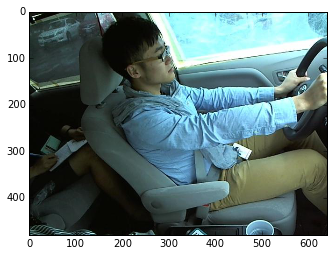

In [44]:
print "\nIdentifying training images:"
train_image_list, train_class_list = split_image_data(driver_list, training_list)
print "First 20 training images: {}".format(train_image_list[:20])
print "First 20 training classes: {}".format(train_class_list[:20])

print "\nIdentifying validation images:"
validation_image_list, validation_class_list = split_image_data(driver_list, validation_list)
print "First 20 validation images: {}".format(validation_image_list[:20])
print "First 20 validation classes: {}".format(validation_class_list[:20])

## Create an inital CNN based on the AlexNet example
Starting with no pre-loaded weights though as we'll train this with our own data

In [45]:
#caffe.set_device(0)     #Needed for GPUs if we have multiple
caffe.set_mode_cpu()    

model_def = './model/state-farm-train-test.prototxt'
model_weights = './model/caffenet-kaggle-state-farm.caffemodel'

net = caffe.Net(model_def,      # defines the structure of the model
                #model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)



## Create LMDBs for training and validating
We'll look at testing later on, but this function is for any list of images/classes independent of purpose.
From https://github.com/BVLC/caffe/issues/1698#issuecomment-70211045 and http://deepdish.io/2015/04/28/creating-lmdb-in-python/

### TODO : Look at transforming the image into the right format now!!!

In [47]:
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
#transformer.set_mean('data', mu)            # subtract the dataset-mean value in each channel
transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR

def load_and_resize_image(filename, transform = False):
    image = caffe.io.load_image(filename)            
    image = caffe.io.resize_image(image, (120, 160), interp_order = 3 )
    if transform == True:
        # BGR (switch from RGB)
        # Channel x Height x Width order (switch from H x W x C)
        # TODO NEXT --> np.uint8 {0, ..., 255}
        #image = image[:,:,::-1]
        #image = image.transpose((2,0,1))
        image = transformer.preprocess('data', image)
    return image
    
def create_lmdb(filename, image_list, class_list):
    img = {}
    #First create the lmdb with the maximum size (it doesn't create this size, just sets the maximum!)
    image_db = lmdb.open(filename, map_size=int(1e12))
    
    #Now iterate the image list, load, resize and store 
    #Note we may need to chunk this into multiple transactions if there are issues with a single txn
    with image_db.begin(write=True) as txn:
        for index, img_filename in enumerate(image_list):
            datum = caffe.proto.caffe_pb2.Datum()
            #Load image
            image = load_and_resize_image(img_filename, transform = True) 
            datum.channels = image.shape[0]
            datum.height = image.shape[1]
            datum.width = image.shape[2]
            datum.data = image.tobytes()
            datum.label = int(class_list[index])
            print 'Writing {:0>10d}'.format(index)
            txn.put('{:0>10d}'.format(index), datum.SerializeToString())
    image_db.close()

#TODO - Check whether the file exists before recreating it??  
#Using head(10) for now to prove it works!!
create_lmdb('model/state-farm-train.lmdb', train_image_list[:10], train_class_list[:10])
#create_lmdb('model/state-farm-validation.lmdb', validation_image_list, validation_class_list)


Writing 0000000000
Writing 0000000001
Writing 0000000002
Writing 0000000003
Writing 0000000004
Writing 0000000005
Writing 0000000006
Writing 0000000007
Writing 0000000008
Writing 0000000009


OR Try to set up a Lenet Mnist model...

In [4]:
from caffe import layers as L, params as P

def lenet(lmdb, batch_size):
    # our version of LeNet: a series of linear and simple nonlinear transformations
    n = caffe.NetSpec()
    
    n.data, n.label = L.Data(batch_size=batch_size, backend=P.Data.LMDB, source=lmdb,
                             transform_param=dict(scale=1./255), ntop=2)
    
    n.conv1 = L.Convolution(n.data, kernel_size=5, num_output=20, weight_filler=dict(type='xavier'))
    n.pool1 = L.Pooling(n.conv1, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    n.conv2 = L.Convolution(n.pool1, kernel_size=5, num_output=50, weight_filler=dict(type='xavier'))
    n.pool2 = L.Pooling(n.conv2, kernel_size=2, stride=2, pool=P.Pooling.MAX)
    n.fc1 =   L.InnerProduct(n.pool2, num_output=500, weight_filler=dict(type='xavier'))
    n.relu1 = L.ReLU(n.fc1, in_place=True)
    n.score = L.InnerProduct(n.relu1, num_output=10, weight_filler=dict(type='xavier'))
    n.loss =  L.SoftmaxWithLoss(n.score, n.label)
    
    return n.to_proto()
    
with open('model/lenet_auto_train.prototxt', 'w') as f:
    f.write(str(lenet('model/mnist_train_lmdb', 64)))
    
with open('model/lenet_auto_validate.prototxt', 'w') as f:
    f.write(str(lenet('model/mnist_validate_lmdb', 100)))
    
with open('model/lenet_auto_test.prototxt', 'w') as f:
    f.write(str(lenet('model/mnist_test_lmdb', 100)))

In [ ]:
solver = caffe.SGDSolver('./model/lenet_auto_train.prototxt')

# just print the weight sizes (we'll omit the biases)
#[(k, v[0].data.shape) for k, v in solver.net.params.items()]

To get an idea of the architecture of our net, we can check the dimensions of the intermediate features (blobs) and parameters (these will also be useful to refer to when manipulating data later).

In [1]:
# just print the weight sizes (we'll omit the biases)
[(k, v[0].data.shape) for k, v in solver.net.params.items()]

NameError: name 'solver' is not defined